In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("clustering.csv", header=None)

In [6]:
df

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186
...,...,...
395,22.423142,50.252807
396,-58.534367,-78.679387
397,36.446549,-11.841887
398,-101.284845,85.096034


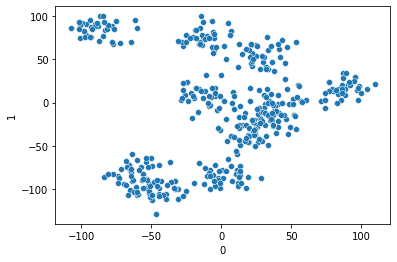

In [8]:
sns.scatterplot(data=df, x=0, y=1)
plt.show()

In [93]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# KMeans

In [26]:
km = KMeans(n_clusters=2)
km.fit(df)

KMeans(n_clusters=2)

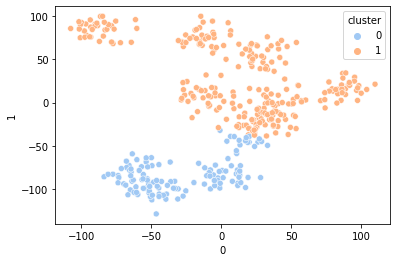

In [75]:
def plot_clusters(clusters, data=df):
    df_ = data.copy()
    df_["cluster"] = clusters
    sns.scatterplot(data=df_, x=0, y=1, hue="cluster", palette="pastel")
    
plot_clusters(km.predict(df))

Dwa klastry to oczywiście za mało, więc trzeba optymalizować. W tym celu wykorzystam `silhouette_score` i `davies_bouldin_score`.

In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [33]:
print("Silhouette score:", silhouette_score(df, df_km["cluster"]))
print("Davies Bouldin score:", davies_bouldin_score(df, df_km["cluster"]))

Silhouette score: 0.4532081344558535
Davies Bouldin score: 0.8003851896614073


In [83]:
def best_cluster_count(model_constructor, score_fun, which=range(2, 16), X=df):
    score_results = []
    
    for i in which:
        model = model_constructor(n_clusters=i)
        clusters = model.fit_predict(X)
        score_results.append(
            score_fun(X, clusters)
        )
    return score_results

def make_scorers_df(model_constructor):
    scores_df = pd.DataFrame({
        "n": [i for i in range(2, 16)],
        "sil score": best_cluster_count(model_constructor, silhouette_score),
        "DB score": best_cluster_count(model_constructor, davies_bouldin_score)
    })
    return scores_df

def plot_scorers(model_constructor):
    sns.lineplot(
        data=make_scorers_df(model_constructor).melt(id_vars=["n"], value_name="score", var_name="scorer"),
        x="n", y="score", hue="scorer"
    )

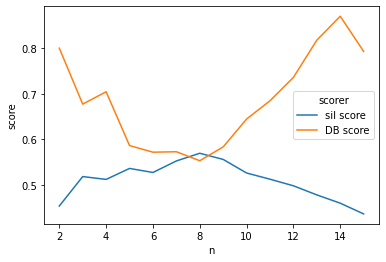

In [84]:
plot_scorers(KMeans)

`silhouette_score` jest im większy tym lepszy, `davies_bouldin_score` im mniejszy tym lepszy. Więc funkcje oceniające się zgadzają, że `n=8` jest optymalne.

In [59]:
km_opt = KMeans(n_clusters=8)
km_opt.fit(df)
df_km_opt = df.copy()
df_km_opt["cluster"] = km_opt.predict(df)

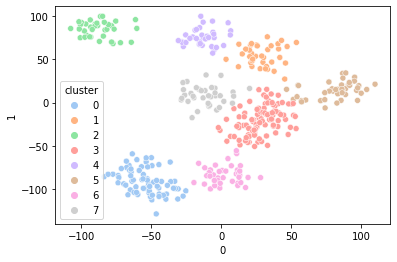

In [60]:
sns.scatterplot(data=df_km_opt, x=0, y=1, hue="cluster", palette="pastel")
plt.show()

Wydaje się nieźle, ale klaster \#3 jest większy od sąsiadów, przez co klaster \#5 "kradnie" kilka punktów. Może uda się temu zapobiec inną metodą.

# Agglomerative Clustering

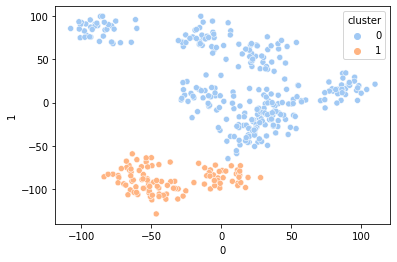

In [76]:
agg = AgglomerativeClustering()
plot_clusters(agg.fit_predict(df))

Nawet bez optymalizacji liczby klastrów, to algorytm "ładnie" podzielił zbiór danych, czyli granica decyzyjna przebiega przez obszar z małą liczbą punktów.

In [90]:
make_scorers_df(AgglomerativeClustering)

,n,sil score,DB score
0,2,0.469546,0.723096
1,3,0.493910,0.756381
2,4,0.511349,0.644273
3,5,0.536817,0.572852
4,6,0.515856,0.555990
5,7,0.536952,0.592236
6,8,0.550694,0.571809
7,9,0.536760,0.586092
8,10,0.522149,0.630781
9,11,0.481245,0.685115


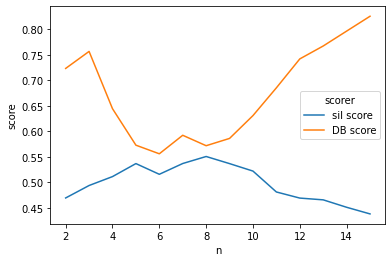

In [85]:
plot_scorers(AgglomerativeClustering) # defaultowe linkage="ward"

Tym razem scorery się nie zgadzają - `davies_bouldin` wskazuje na `n=6` lub `n=8` jako optymalną liczbę klastrów, a `silhouette` na `n=8`. Ma również nietypowy wynik dla `n=5`, bliski optymalnemu.

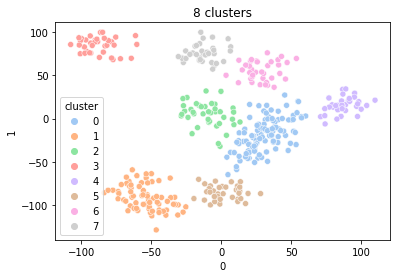

In [108]:
plot_clusters(AgglomerativeClustering(n_clusters=8).fit_predict(df))
plt.title("8 clusters")
plt.show()

Udało się rozwiązać problem "kradzieży" punktów i faktycznie `n=8` wydaje się najbardziej optymalne, ale warto się przyjrzeć co się działo w pozostałych klastrowaniach. Zwłaszcza w tym, które `davies_bouldin` preferował od tego.

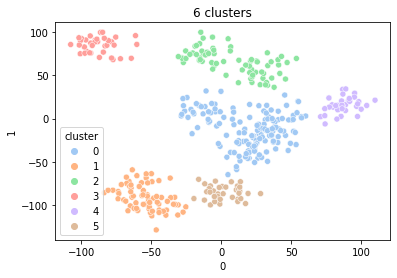

In [109]:
plot_clusters(AgglomerativeClustering(n_clusters=6).fit_predict(df))
plt.title("6 clusters")
plt.show()

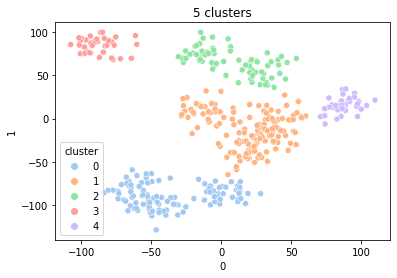

In [106]:
plot_clusters(AgglomerativeClustering(n_clusters=5).fit_predict(df))
plt.title("5 clusters")
plt.show()

Inne klastrowania też wydają się okej. 
Miałem nadzieję, że będzie się dało zauważyć jakąś różnicę, która powodowałaby rozbieżności wyników, ale nie widzę takiej.

Być może jest to spowodowane niewypukłością klastra \#1 (dla `n=6`). 
Gdy jest połączony z klastrem \#5 to dla metryki `silhouette` wydaje się lepszy, ponieważ ta metryka nagradza wypukłe kształty klastrów bardziej niż `davies_bouldin`.